In [ ]:
!pip install xgboost lightgbm imbalanced-learn


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE


In [ ]:
df = pd.read_csv('/content/aug_train.csv')
df.head()


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [ ]:
df.shape
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

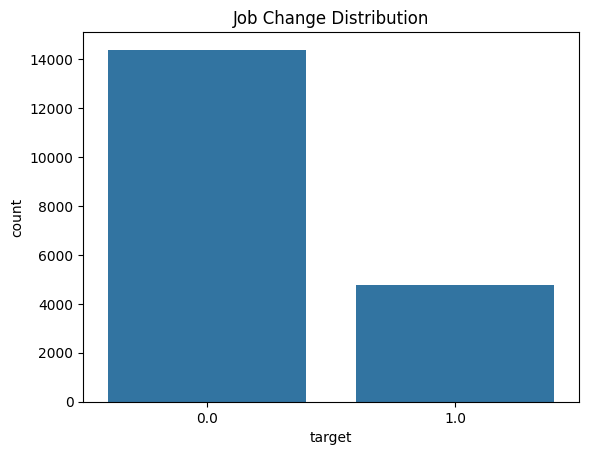

In [ ]:
sns.countplot(x='target', data=df)
plt.title("Job Change Distribution")
plt.show()


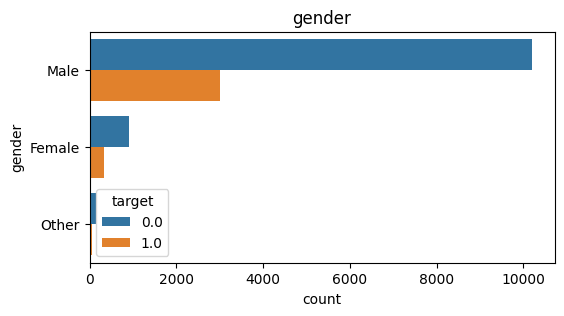

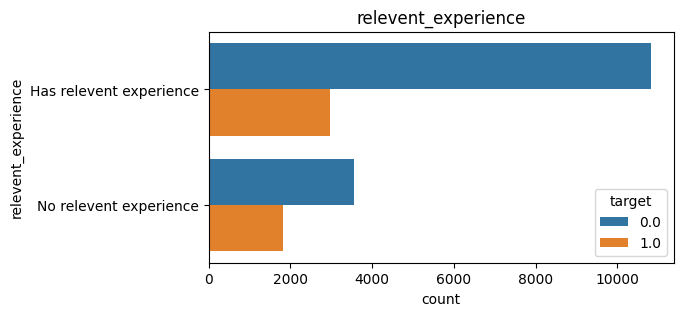

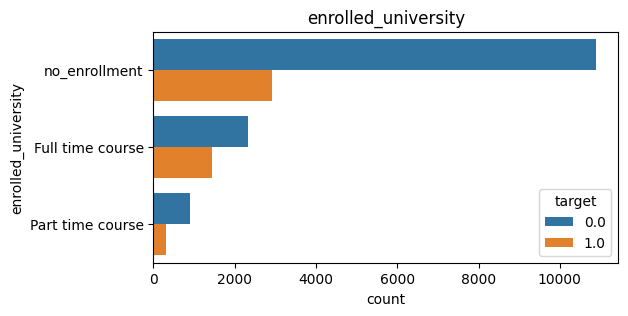

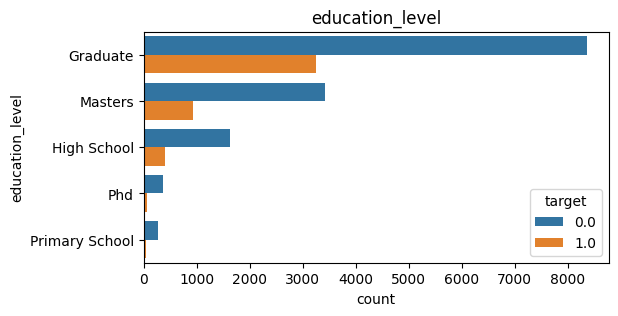

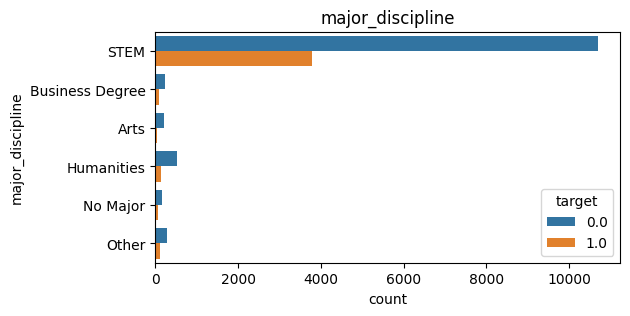

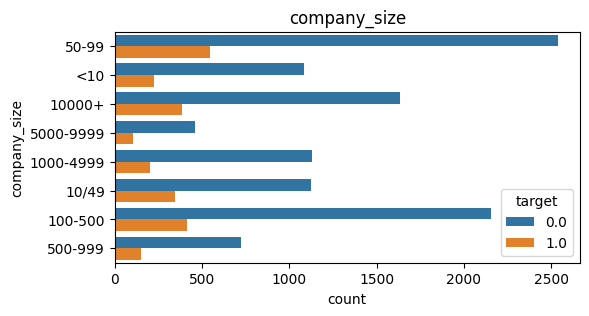

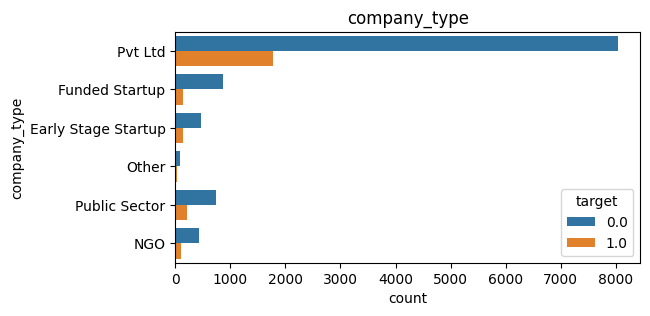

In [ ]:
categorical_cols = [
    'gender','relevent_experience','enrolled_university',
    'education_level','major_discipline','company_size','company_type'
]

for col in categorical_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(y=col, hue='target', data=df)
    plt.title(col)
    plt.show()



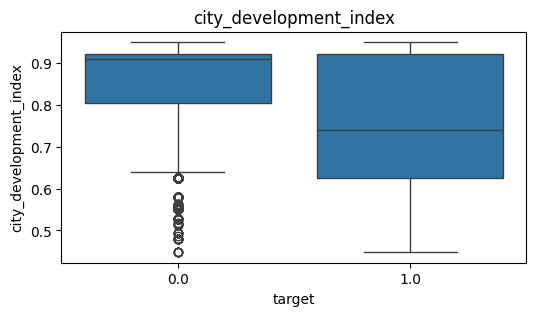

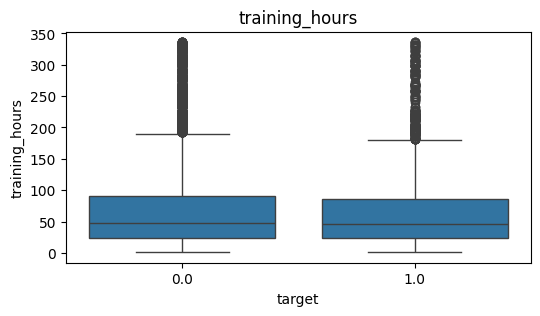

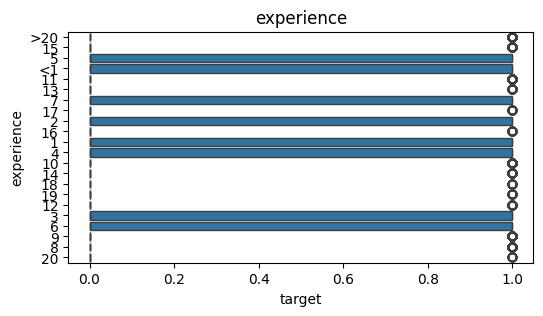

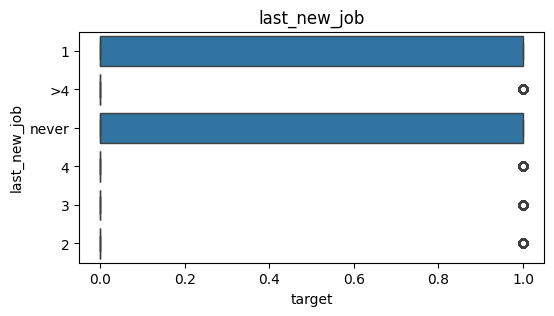

In [ ]:
numerical_cols = ['city_development_index','training_hours','experience','last_new_job']

for col in numerical_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x='target', y=col, data=df)
    plt.title(col)
    plt.show()


In [ ]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)


/tmp/ipython-input-3797650491.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-3797650491.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [ ]:
le = LabelEncoder()
for col in df.select_dtypes(include='object'):
    df[col] = le.fit_transform(df[col])


In [ ]:
X = df.drop('target', axis=1)
y = df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "LightGBM": LGBMClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"{name} Accuracy:", accuracy_score(y_test, preds))
    y_proba = model.predict_proba(X_test)[:,1]
    results.append({"Model": name, "Accuracy": accuracy_score(y_test, preds), "ROC_AUC": roc_auc_score(y_test, y_proba)})


Logistic Regression Accuracy: 0.6865982965409352
Random Forest Accuracy: 0.8524248218320876
[LightGBM] [Info] Number of positive: 11505, number of negative: 11504
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2466
[LightGBM] [Info] Number of data points in the train set: 23009, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500022 -> initscore=0.000087
[LightGBM] [Info] Start training from score 0.000087


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.8423431253259169
XGBoost Accuracy: 0.8433860594472449


In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_proba)
    }


In [ ]:
results_df = pd.DataFrame(results)
results_df


,Model,Accuracy,ROC_AUC
0,Logistic Regression,0.686598,0.740231
1,Random Forest,0.852425,0.924451
2,LightGBM,0.842343,0.918950
3,XGBoost,0.843386,0.917534


In [ ]:
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}


In [ ]:
xgb = XGBClassifier(eval_metric='logloss')

random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_grid,
    n_iter=25,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)


Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [4, 6, 8],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [200, 300, 400],
                                        'subsample': [0.7, 0.8, 0.9]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [ ]:
best_xgb = random_search.best_estimator_
random_search.best_params_


{'subsample': 0.7,
 'n_estimators': 300,
 'min_child_weight': 5,
 'max_depth': 8,
 'learning_rate': 0.05,
 'gamma': 0.1,
 'colsample_bytree': 0.9}

In [ ]:
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


Accuracy: 0.844950460629237
ROC-AUC: 0.9192328200784796
              precision    recall  f1-score   support

         0.0       0.85      0.84      0.84      2877
         1.0       0.84      0.85      0.85      2876

    accuracy                           0.84      5753
   macro avg       0.84      0.84      0.84      5753
weighted avg       0.84      0.84      0.84      5753



In [ ]:
thresholds = np.arange(0.3, 0.7, 0.01)
best_threshold = 0
best_acc = 0

for t in thresholds:
    preds = (y_proba >= t).astype(int)
    acc = accuracy_score(y_test, preds)
    if acc > best_acc:
        best_acc = acc
        best_threshold = t

best_threshold, best_acc


(np.float64(0.5100000000000002), 0.8468625065183383)

In [ ]:
df['job_change_probability'] = best_xgb.predict_proba(X_scaled)[:,1]
df['prediction'] = (df['job_change_probability'] >= best_threshold).astype(int)

df.to_csv('employee_retention_predictions.csv', index=False)
